In [ ]:
%load_ext autoreload
%autoreload 2

: 

In [17]:
from src.utils import load_model_and_tokenizer, obtain_all_ice_variants, train_test_split_per_template, evaluate
from src.function_vectors import generate_head_activations_last_token, compute_head_impact, extract_and_average_head_activations, apply_function_vector
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

torch.set_grad_enabled(False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

MODEL_NAME = 'meta-llama/Llama-3.1-8B'
DATASET_PATH = './data/llama_3_data.pt'

### Load the model and the dataset

In [3]:
tokenizer, model = load_model_and_tokenizer(MODEL_NAME, device)
dataset = torch.load(DATASET_PATH)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loaded pretrained model meta-llama/Llama-3.1-8B into HookedTransformer


### Preprocess the dataset and divide it into validation and test sets

In [4]:
val, test = train_test_split_per_template(dataset, test_size=0.4, num_samples_per_template=50)

val_no_ice, val_single_ice, val_two_ice, val_all_ice = obtain_all_ice_variants(val)
test_no_ice, test_single_ice, test_two_ice, test_all_ice = obtain_all_ice_variants(test)
val_sets = [val_no_ice, val_single_ice, val_two_ice, val_all_ice]
test_sets = [test_no_ice, test_single_ice, test_two_ice, test_all_ice]

### Evaluate the model on the validation and test sets

In [5]:
results_val_no_ice, results_val_single_ice, results_val_two_ice, results_val_all_ice = [evaluate(tokenizer, model, val_set, batch_size=10, prepend_bos=True) for val_set in val_sets]
results_test_no_ice, results_test_single_ice, results_test_two_ice, results_test_all_ice = [evaluate(tokenizer, model, test_set, batch_size=10, prepend_bos=True) for test_set in test_sets]
results_val = [results_val_no_ice, results_val_single_ice, results_val_two_ice, results_val_all_ice]
results_test = [results_test_no_ice, results_test_single_ice, results_test_two_ice, results_test_all_ice]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

In [6]:
print("Validation Results (No ICE, Single ICE, Two ICE, All ICE):", [np.round(np.mean(res), 3) for res in results_val])
print("Test Results (No ICE, Single ICE, Two ICE, All ICE):", [np.round(np.mean(res), 3) for res in results_test])

Validation Results (No ICE, Single ICE, Two ICE, All ICE): [0.306, 0.733, 0.767, 0.783]
Test Results (No ICE, Single ICE, Two ICE, All ICE): [0.3, 0.767, 0.75, 0.817]


### Extract vectors that attention heads write to the residual stream of the final token
Perform extraction only from correctly solved instances

In [7]:
solved_prompts_val_full_ice = [item[0] for idx, item in enumerate(val_all_ice) if results_val_all_ice[idx] == 1]
activations = generate_head_activations_last_token(model, solved_prompts_val_full_ice, batch_size=1)
activations = torch.stack(activations, dim=0)

  0%|          | 0/15 [00:00<?, ?it/s]

### Compute the impact of each head's on the logit of the correct answer on the validation set

In [ ]:
# attenton: running this cell might take a while
# head_importances = compute_head_impact(model, tokenizer, val_no_ice, activations, batch_size=10)

  0%|          | 0/32 [00:00<?, ?it/s]

save head impacts

In [8]:
# torch.save(head_importances, './data/llama_3_function_vector_head_impacts.pt')
head_importances = torch.load('./data/llama_3_function_vector_head_impacts.pt')

### Plot head impacts

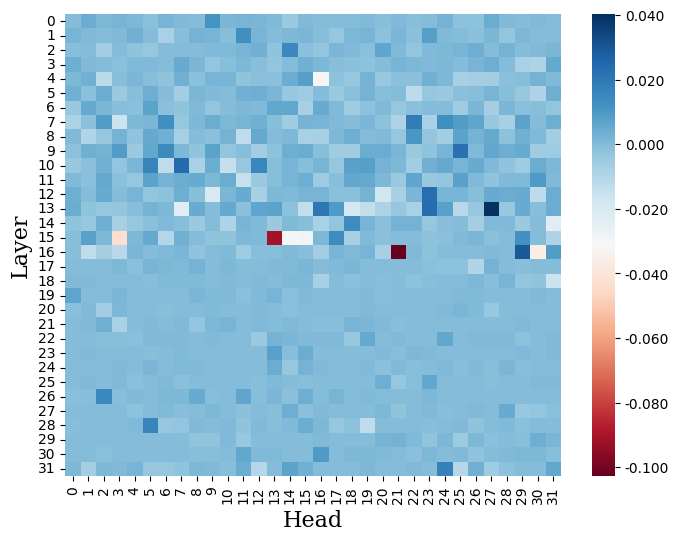

In [9]:
plt.figure(figsize=(8, 6))
sns.heatmap(head_importances, annot=False, cmap='RdBu', fmt='.2f', cbar_kws={'format': '%.3f'})
plt.xlabel('Head', fontsize=16, fontname='DeJavu Serif')
plt.ylabel('Layer', fontsize=16, fontname='DeJavu Serif')
plt.show()

### Select top-k heads based on their impact

In [11]:
top = 10 
num_random_head_samples = 5

num_layers, num_heads = head_importances.shape
top_head_indices = torch.topk(head_importances.flatten(), top).indices
num_random_head_samples = [torch.randperm(len(head_importances.flatten()))[:top] for _ in range(num_random_head_samples)]

top_heads = [((idx // num_heads).item(), (idx % num_heads).item()) for idx in top_head_indices]
random_heads = [[((idx // num_heads).item(), (idx % num_heads).item()) for idx in rand_indices] for rand_indices in num_random_head_samples]

### Create Function Vector

In [16]:
function_vector = extract_and_average_head_activations(model, top_heads, activations) 
function_vectors_random = [extract_and_average_head_activations(model, rand_heads, activations) for rand_heads in random_heads]

### Apply Function Vector and evaluate its effect on performance

In [22]:
results_function_vector = apply_function_vector(model, tokenizer, test_no_ice, function_vector.to(model.cfg.device), batch_size=10)
results_function_vector_random = [apply_function_vector(model, tokenizer, test_no_ice, function_vector_random.to(model.cfg.device), batch_size=10) for function_vector_random in function_vectors_random]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

### Plot results

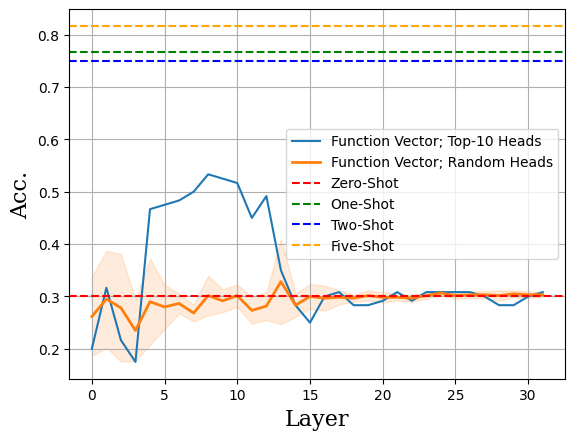

In [24]:
layers = np.arange(len(results_function_vector))

# Top-10 heads function vector results
plt.plot(results_function_vector, label='Function Vector; Top-10 Heads')

# Mean and std across random runs
random_results = np.array(results_function_vector_random, dtype=float)
mean_random = random_results.mean(axis=0)
std_random = random_results.std(axis=0)
plt.plot(layers, mean_random, color='C1', linewidth=2, label='Function Vector; Random Heads')
plt.fill_between(layers, mean_random - std_random, mean_random + std_random,
                 color='C1', alpha=0.15)

# Baselines with in-context examples
plt.axhline(y=np.mean(np.mean(results_test_no_ice)), color='r', linestyle='--', label='Zero-Shot')
plt.axhline(y=np.mean(np.mean(results_test_single_ice)), color='g', linestyle='--', label='One-Shot')
plt.axhline(y=np.mean(np.mean(results_test_two_ice)), color='b', linestyle='--', label='Two-Shot')
plt.axhline(y=np.mean(np.mean(results_test_all_ice)), color='orange', linestyle='--', label='Five-Shot')
plt.xlabel('Layer', fontsize=16, fontname='DeJavu Serif')
plt.ylabel('Acc.', fontsize=16, fontname='DeJavu Serif')
plt.grid()
plt.legend()